## Case 1: Asset $j$ (aka r2 aka R-1) bought in quantity $-\Delta R_j$ with asset $i$ (aka r1 aka R-0)

In [1]:
import pandas as pd

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *

########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
# omniHDXABC is HDX shares dedicated to pool of token ABC

trader = {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader}

########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_r2_for_r1': {'token_buy': 'R1', 'token_sell': 'R2', 'amount_sell': 5000, 'action_id': 'Trade',
                       'agent_id': 'Trader'},
    'sell_r1_for_r2': {'token_sell': 'R1', 'token_buy': 'R2', 'amount_buy': 1000, 'action_id': 'Trade',
                       'agent_id': 'Trader'}
}

# list of (action, number of repetitions of action), timesteps = sum of repititions of all actions
trade_count = 1
action_ls = [('trade', trade_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trade': {'sell_r2_for_r1': 0.0,
              'sell_r1_for_r2': 1.0}  # really buy_r2_with_r1
}

########## CFMM INITIALIZATION ##########

initial_values = {
    'token_list': ['R1', 'R2'],
    'R': [500000, 1500000],
    'P': [2, 2 / 3],
    'fee_assets': 0.0015,
    'fee_HDX': 0.0015
}

############################################ SETUP ##########################################################

config_params = {
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()

rdf, agent_df = processing.postprocessing(events)

print(agent_df.tail(20))




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Is this trade type sell called?
Is this trade type sell called?
Total execution time: 0.10s
   simulation  subset  run  substep  timestep agent_label          q  s-0  \
3           0       0    1        3         1      Trader 1000000.00    0   

   s-1       r-0        r-1  p-0  p-1  
3    0 999665.22 1001000.00    0    0  


In [2]:
agent_df.head()

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
3,0,0,1,3,1,Trader,1000000.00,0,0,999665.22,1001000.00,0,0


In [3]:
rdf.head()

,R-0,R-1,Q-0,Q-1,S-0,S-1,A-0,A-1,B-0,B-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
0,500000.00,1500000.00,1000000.00,1000000.00,500000,1500000,0,0,500000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,0,0
3,500334.78,1499000.00,999330.88,1000669.12,500000,1500000,0,0,500000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,1


In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame(events)

,external,AMM,uni_agents,simulation,subset,run,substep,timestep
0,{},"{'R': [500000, 1500000], 'Q': [1000000, 100000...","{'Trader': {'q': 1000000, 's': [0, 0], 'r': [1...",0,0,1,0,0
1,{},"{'R': [500000, 1500000], 'Q': [1000000, 100000...","{'Trader': {'q': 1000000, 's': [0, 0], 'r': [1...",0,0,1,1,1
2,{},"{'R': [500334.7829714985, 1499000.0000000002],...","{'Trader': {'q': 1000000.0, 's': [0, 0], 'r': ...",0,0,1,2,1
3,{},"{'R': [500334.7829714985, 1499000.0000000002],...","{'Trader': {'q': 1000000.0, 's': [0, 0], 'r': ...",0,0,1,3,1


[0]


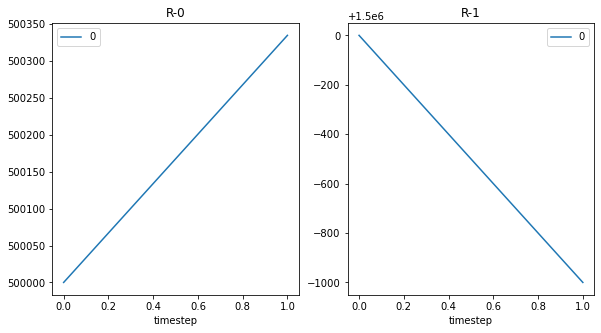

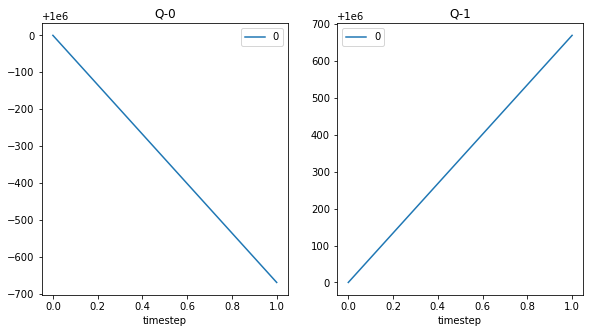

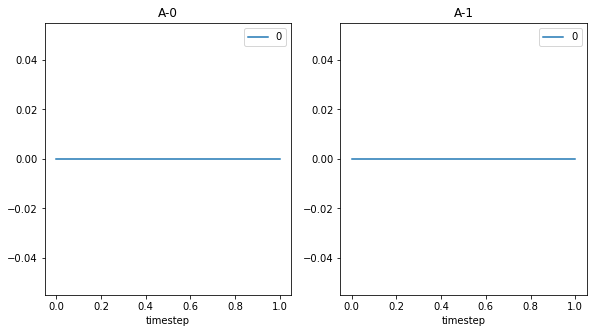

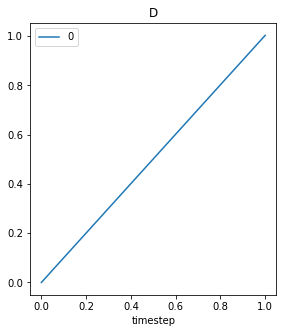

In [5]:

var_list = ['R', 'Q', 'A', 'D']
plot_vars(rdf, var_list)

#### Case 1: Asset $j$ bought in quantity $-\Delta R_j$ with asset $i$
$$
\begin{align}
\tilde{\Delta Q_j} &= Q_j\frac{- \Delta R_j}{R_j(1 - f_A) + \Delta R_j}\\
\tilde{\Delta Q_i} &= -\frac{\tilde{\Delta Q_j}}{1 - f_P}\\
\Delta R_i &= R_i\frac{- \tilde{\Delta Q_i}}{Q_i + \tilde{\Delta Q_i}}
\end{align}
$$

Now that the correct $\Delta R_i$ is computed, we can treat this trade as a "sell" trade of asset $i$ in quantity $\Delta R_i$.

In [6]:
# KEY for getting verification to pass
# sign convention is amount to buy is negated
action_dict['sell_r1_for_r2']['amount_buy'] = -action_dict['sell_r1_for_r2']['amount_buy']


In [7]:
delta_tilde_qj = rdf['Q-1'][0] * (-action_dict['sell_r1_for_r2']['amount_buy'])/(rdf['R-1'][0]*(1-initial_values['fee_assets'])+action_dict['sell_r1_for_r2']['amount_buy'])
delta_tilde_qj

668.1142475363287

In [8]:
delta_tilde_qi = -delta_tilde_qj / (1-initial_values['fee_HDX'])
delta_tilde_qi

-669.117924422963

In [9]:
delta_ri = rdf['R-0'][0] * (-delta_tilde_qi)/(rdf['Q-0'][0]+delta_tilde_qi)
delta_ri

334.7829714985027

In [10]:
# delta_rj = -action_dict['sell_r1_for_r2']['amount_buy']
# delta_rj

#### Case 2: Asset $i$ sold in quantity $\Delta R_i$ for asset $j$

Asset $i$ is sold for asset $j$ in a series of trades, with 
$$
\begin{align}
\Delta Q_i &= Q_i\frac{- \Delta R_i}{R_i + \Delta R_i}\\
\Delta Q_j' &= -\Delta Q_i (1 - f_P)\\
\Delta R_j' &= R_j\frac{- \Delta Q_j'}{Q_j + \Delta Q_j'}\\
\Delta R_j &= \Delta R_j'(1 - f_A)
\end{align}
$$

In [11]:
delta_qi = rdf['Q-0'][0] * (-delta_ri)/(rdf['R-0'][0]+delta_ri)
delta_qi

-669.117924422963

In [12]:
delta_qj_prime = -delta_qi * (1-initial_values['fee_HDX'])
delta_qj_prime

668.1142475363287

In [13]:
delta_rj_prime = rdf['R-1'][0] * (-delta_qj_prime)/(rdf['Q-1'][0]+delta_qj_prime)
delta_rj_prime

-1001.50225338007

In [14]:
delta_rj = delta_rj_prime*(1-initial_values['fee_assets'])
delta_rj

-999.9999999999999

### Fee accounting
The LHDX fee is added to treasury
$$
\Delta D = -\Delta Q_i f_P
$$

It is helpful to consider $\Delta R_j'$, the amount initially swapped out given $\Delta R_i$ before the asset fee is added back to the $j$ pool.

Note that $\Delta R_j = (1 - f_A) \Delta R_j'$. The spot price immediately after the $j$ swap is $\frac{Q_j + \Delta Q_j'}{R_j + \Delta R_j'}$.
Thus we want
$$
\frac{Q_j^+}{R_j^+} = \frac{Q_j + \Delta Q_j'}{R_j + \Delta R_j'}
$$

Solving this for $Q_j^+$, we see that
$$
\begin{align}
R_j^+ &= R_j + \Delta R_j\\
Q_j^+ &= R_j^+ \frac{Q_jR_j}{\left(R_j + \frac{\Delta R_j}{1 - f_A}\right)^2}
\end{align}
$$

In [15]:
delta_d = -delta_qi*initial_values['fee_HDX']
delta_d

1.0036768866344445

In [16]:
R_j_plus = rdf['R-1'][0] + (delta_rj)
R_j_plus

1499000.0

In [17]:
Q_j_plus = R_j_plus * rdf['Q-1'][0] * rdf['R-1'][0] / (rdf['R-1'][0] + ((delta_rj)/(1-initial_values['fee_assets'])))**2
Q_j_plus

1000669.1170884727

#### $Q_j$ Check

In [18]:
rdf['Q-1'][3]# == Q_j_plus

1000669.1170884727

In [19]:
rdf['Q-1'][3] == Q_j_plus

True

#### $Q_i$ Check

In [20]:
rdf['Q-0'][3] == rdf['Q-0'][0] + (delta_qi)

True

In [21]:
rdf['Q-0'][3]

999330.882075577

In [22]:
rdf['Q-0'][0] + (delta_qi)  # SIGN CHANGE

999330.882075577

#### $R_i$ Check

In [23]:
rdf['R-0'][3] == rdf['R-0'][0] + (delta_ri)

True

In [24]:
rdf['R-0'][0] + (delta_ri)

500334.7829714985

In [25]:
rdf['R-0'][3]

500334.7829714985

#### $R_j$ Check

In [26]:
round(rdf['R-1'][3],8) == rdf['R-1'][0] + (delta_rj)

True

In [27]:
rdf['R-1'][0] + (delta_rj)

1499000.0

In [28]:
rdf['R-1'][3]

1499000.0000000002